## Figure 5 (d)-(f) Reproduction

This notebook contains code for reproducing the in silico perturbation analysis results presented in Figure 5 (panels d-f).

### Data Availability

The required datasets for this analysis can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1I2zSn4A94f8wLSxz-Rfn8CfirgxOtsPP?usp=sharing).

### Overview

The script perform analysis to examine species interaction effects by:
- Loading baseline and perturbed grid occupation values
- Performing linear regression analysis with prediction intervals
- Identifying outlier species that respond unexpectedly to perturbations
- Generating visualizations

### Data Files Required

Place the following files in the `./` directory:
- `NA_coord.txt` - Spatial coordinates
- `NA_background.txt` - Baseline values before perturbation
- `NA_addition.txt` - Values after perturbation
- `NA_grid_num.txt` - Grid number
- `NA_genus.txt` - Species names

Coordinates shape: (29140, 2)
Baseline values: 772
Perturbed values: 772
Grid numbers: 772
Species names: 772

Analyzing target 438: ['Myodes rutilus']
Number of outliers: 17
Outlier indices: [  9  76  92 195 207 336 353 437 481 484 559 611 692 710 746 761 768]

Analyzing target 76: ['Canis latrans']
Number of outliers: 15
Outlier indices: [ 92 175 319 353 362 390 437 484 486 544 559 561 611 692 715]

Analyzing target 761: ['Vulpes vulpes']
Number of outliers: 23
Outlier indices: [ 41  45  51  92 195 274 336 339 346 347 390 484 508 530 544 549 559 561
 626 658 692 705 710]


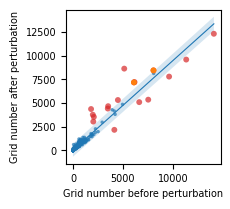

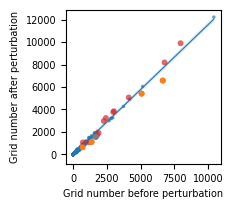

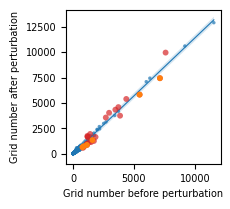

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

# Load perturbation analysis data
def load_perturbation_data(base_path='./'):
    """Load all perturbation analysis data files."""
    data = {
        'coordinates': np.loadtxt(f'{base_path}NA_coord.txt'),
        'baseline_values': np.loadtxt(f'{base_path}NA_background.txt'),
        'perturbed_values': np.loadtxt(f'{base_path}NA_addition.txt'),
        'grid_numbers': np.loadtxt(f'{base_path}NA_grid_num.txt').tolist(),
        'species_names': [[f'{x[0]} {x[1]}'] for x in 
                        np.genfromtxt(f'{base_path}NA_genus.txt', dtype=str)]
    }
    
    # Print data summary
    print(f"Coordinates shape: {data['coordinates'].shape}")
    print(f"Baseline values: {len(data['baseline_values'])}")
    print(f"Perturbed values: {len(data['perturbed_values'])}")
    print(f"Grid numbers: {len(data['grid_numbers'])}")
    print(f"Species names: {len(data['species_names'])}")
    
    return data

def perform_outlier_analysis(baseline_values, perturbed_values, target_index, alpha=0.01):
    """
    Perform linear regression and outlier detection for perturbation analysis.
    
    Parameters:
    -----------
    baseline_values : array-like
        Values before perturbation
    perturbed_values : array-like
        Values after perturbation
    target_index : int
        Index of the target being perturbed
    alpha : float
        Significance level for prediction intervals
    
    Returns:
    --------
    dict : Analysis results including model, outliers, and plotting data
    """
    # Prepare data
    x = baseline_values.copy()
    y = perturbed_values.copy()
    x[target_index] = 0
    y[target_index] = 0
    
    # Clean data
    valid_mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[valid_mask]
    y_clean = y[valid_mask]
    original_indices = np.where(valid_mask)[0]
    
    # Fit linear model
    X = x_clean.reshape(-1, 1)
    model = LinearRegression().fit(X, y_clean)
    y_pred = model.predict(X)
    
    # Calculate prediction intervals
    residuals = y_clean - y_pred
    n = len(x_clean)
    dof = n - 2
    mse = np.sum(residuals**2) / dof
    se = np.sqrt(mse)
    
    mean_x = np.mean(x_clean)
    sxx = np.sum((x_clean - mean_x)**2)
    se_pred = se * np.sqrt(1 + 1/n + (x_clean - mean_x)**2 / sxx)
    
    t_val = stats.t.ppf(1 - alpha/2, dof)
    lower_bound = y_pred - t_val * se_pred
    upper_bound = y_pred + t_val * se_pred
    
    # Identify outliers
    outlier_mask = (y_clean < lower_bound) | (y_clean > upper_bound)
    outlier_indices = original_indices[outlier_mask]
    
    return {
        'x_clean': x_clean,
        'y_clean': y_clean,
        'model': model,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outlier_mask': outlier_mask,
        'outlier_indices': outlier_indices,
        'original_indices': original_indices
    }

def plot_perturbation_analysis(results, highlight_indices=None, highlight_indices_alt=None,
                               figsize=(2, 2), font_size=7, colors=None):
    """
    Create a visualization of the perturbation analysis.
    
    Parameters:
    -----------
    results : dict
        Output from perform_outlier_analysis
    highlight_indices : list
        Indices to highlight in primary color
    highlight_indices_alt : list
        Indices to highlight in alternative color
    figsize : tuple
        Figure size
    font_size : int
        Font size for labels
    colors : list
        Color palette (defaults to seaborn palette)
    """
    if colors is None:
        colors = sns.color_palette()
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.rcParams['font.size'] = font_size
    ax.tick_params(axis='both', which='both', labelsize=font_size)
    
    x_clean = np.ravel(results['x_clean'])
    y_clean = np.ravel(results['y_clean'])
    outlier_mask = results['outlier_mask']
    
    # Plot base points
    ax.scatter(x_clean[~outlier_mask], y_clean[~outlier_mask], 
              s=6, alpha=0.7, zorder=1, edgecolors='none')
    
    # Plot outliers
    ax.scatter(x_clean[outlier_mask], y_clean[outlier_mask], 
              s=18, alpha=0.7, color=colors[3], zorder=3, edgecolors='none')
    
    # Plot regression line
    x_line = np.linspace(x_clean.min(), x_clean.max(), 100).reshape(-1, 1)
    y_line = results['model'].predict(x_line)
    ax.plot(x_line.ravel(), y_line.ravel(), 
           linestyle='-', linewidth=0.8, color='tab:blue', zorder=2)
    
    # Plot prediction interval
    x_sorted_idx = np.argsort(x_clean)
    ax.fill_between(
        x_clean[x_sorted_idx],
        results['lower_bound'][x_sorted_idx],
        results['upper_bound'][x_sorted_idx],
        alpha=0.18, color='tab:blue', zorder=1, edgecolor='none'
    )
    
    # Highlight specific points
    if highlight_indices:
        valid_highlights = [i for i in highlight_indices if 0 <= i < len(x_clean)]
        if valid_highlights:
            ax.scatter(x_clean[valid_highlights], y_clean[valid_highlights], 
                      s=18, color=colors[1], zorder=4, edgecolors='none')
    
    if highlight_indices_alt:
        valid_highlights = [i for i in highlight_indices_alt if 0 <= i < len(x_clean)]
        if valid_highlights:
            ax.scatter(x_clean[valid_highlights], y_clean[valid_highlights], 
                      s=18, color=colors[7], zorder=4, edgecolors='none')
    
    # Labels
    ax.set_xlabel('Grid number before perturbation', fontsize=font_size)
    ax.set_ylabel('Grid number after perturbation', fontsize=font_size)
    
    return fig, ax

def analyze_perturbation_target(data, target_index, highlight_primary=None, 
                                highlight_secondary=None, alpha=0.01):
    """
    Analyze and visualize perturbation effects for a specific target.
    
    Parameters:
    -----------
    data : dict
        Loaded perturbation data
    target_index : int
        Index of target to analyze
    highlight_primary : list
        Primary indices to highlight
    highlight_secondary : list
        Secondary indices to highlight
    alpha : float
        Significance level
    """
    print(f"\nAnalyzing target {target_index}: {data['species_names'][target_index]}")
    
    results = perform_outlier_analysis(
        data['baseline_values'][target_index],
        data['perturbed_values'][target_index],
        target_index,
        alpha=alpha
    )
    
    print(f"Number of outliers: {len(results['outlier_indices'])}")
    print(f"Outlier indices: {results['outlier_indices']}")
    
    outlier_genera = [data['species_names'][i] for i in results['outlier_indices']]
    
    fig, ax = plot_perturbation_analysis(
        results,
        highlight_indices=highlight_primary,
        highlight_indices_alt=highlight_secondary
    )
    
    return results, outlier_genera, fig

# Main execution
if __name__ == "__main__":
    # Load data
    perturbation_data = load_perturbation_data()
    
    # Analysis 1: Target index 438
    results1, outliers1, fig1 = analyze_perturbation_target(
        perturbation_data, 
        target_index=438,
        highlight_primary=[76, 761]
    )
    
    # Analysis 2: Target index 76
    results2, outliers2, fig2 = analyze_perturbation_target(
        perturbation_data,
        target_index=76,
        highlight_primary=[544, 552, 559, 561],
        highlight_secondary=[437]
    )
    
    # Analysis 3: Target index 761
    results3, outliers3, fig3 = analyze_perturbation_target(
        perturbation_data,
        target_index=761,
        highlight_primary=[544, 548, 549, 552, 559, 561]
    )
    
    plt.show()